This notebook shows how the explainability graphs were created, see explainability

In [3]:
global _debug
_debug = False

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pathlib import Path

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

sns.set_theme()

### Formatting function for plot axes

In [5]:
def format_axis_commas(ax, axis):
    """
    Formats the y-axis tick labels to 
    include commas as thousands separators.
    """
    if axis == 'y':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.yaxis.set_major_formatter(formatter)
    elif axis == 'x':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.xaxis.set_major_formatter(formatter)

#### Callback for logging rewards across parallel environments during Agent training

In [6]:
class VecRewardLogger(BaseCallback):
    """
    Callback for tracking Agent reward progress across training Epochs
    """
    def __init__(self, verbose=0):
        # Reward logging init
        super(VecRewardLogger, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = None
    
    def _on_training_start(self):
        # Initialize on training start to get the number of environments
        self.episode_rewards = np.zeros(self.model.env.num_envs)

    def _on_step(self) -> bool:
        """ This method is called after each step """
        # Update rewards for all environments
        self.episode_rewards += np.array(self.locals['rewards'])
        # Check if any episode is done
        if np.any(self.locals['dones']):
            avg_episode_reward = np.mean(self.episode_rewards)
            self.rewards.append(avg_episode_reward)
            if self.verbose > 0:
                print("Logged rewards for completed episodes:", [self.rewards[-1]])
        return True  # Always return True to continue training

### Callback for setting learning rate schedule across Epochs

In [7]:
class LearningRateScheduler(BaseCallback):
    """
    Callback for setting agent learning rate schedule across trainig Epochs
    """
    def __init__(self, initial_rate, schedule_func, total_timesteps, epoch_timesteps, verbose=0):
        # LR schedule init
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_learning_rate = initial_rate
        self.schedule_func = schedule_func
        self.total_timesteps = total_timesteps
        self.epoch_timesteps = epoch_timesteps
    
    def _on_training_start(self):
        # Initialize LR
        self.model.policy.optimizer.param_groups[0]['lr'] = self.initial_learning_rate
    
    def _on_step(self) -> bool:
        # Update LR based on schedule function
        total_steps = self.num_timesteps + self.model._num_timesteps_at_start
        epoch = total_steps // self.epoch_timesteps
        updated_lr = self.schedule_func(epoch)
        self.model.policy.optimizer.param_groups[0]['lr'] = updated_lr
        return True

In [8]:
def exponential_schedule(initial_lr, decay_rate):
    """
    Exponential decay learning rate schedule.
    Parameters:
        initial_lr (float): The initial learning rate.
        decay_rate (float): The rate of decay, larger values mean more decay.
    Returns: 
        func (object): Function to compute the lr given the fraction of the training completed.
    """
    def func(epoch):
        return initial_lr * np.exp((-decay_rate * epoch))
    return func

# Random locations

In [9]:
unique_genload_samplehalf = np.load("ChrisNotebooks/nodes_train.pkl.npy", allow_pickle = True)
unique_genload_samplehalftest = np.load("ChrisNotebooks/nodes_test.pkl.npy", allow_pickle = True)
input_file = "ChrisNotebooks/RT_LMPS_only_Oct20_Mar24.h5"  # Change this to the path of your HDF5 file

# Load data from HDF5 file
rt_lmps = pd.read_hdf(input_file, key="data")
input_file = "ChrisNotebooks/DA_LMPS_only_Oct20_Mar24.h5"  # Change this to the path of your HDF5 file
da_lmps = pd.read_hdf(input_file, key="data")


In [10]:

# Load data from HDF5 file
rt_lmps_train = rt_lmps[rt_lmps['NODE'].isin(unique_genload_samplehalf)]
rt_lmps_test = rt_lmps[rt_lmps['NODE'].isin(unique_genload_samplehalftest)]
da_lmps_train = da_lmps[da_lmps['NODE'].isin(unique_genload_samplehalf)]
da_lmps_test = da_lmps[da_lmps['NODE'].isin(unique_genload_samplehalftest)]
def random_node_df():
    random_node = np.random.choice(unique_genload_samplehalf,1)[0]
    print(random_node)
    rt_lmps_node_long = pd.wide_to_long(rt_lmps_train.query(f'NODE == "{random_node}"'),'HE',i=rt_lmps_train.columns[:4], j='HourEnding')
    da_lmps_node_long = pd.wide_to_long(da_lmps_train.query(f'NODE == "{random_node}"'),'HE',i=da_lmps_train.columns[:4], j='HourEnding')
    rt_lmps_node_long.columns = ['RT_LMP']
    da_lmps_node_long.columns = ['DA_LMP']
    node_dart = rt_lmps_node_long.merge(da_lmps_node_long, on = rt_lmps_node_long.index.names)
    return node_dart

In [11]:
random_node_df() # takes about 3 s

NSP.MARSHSOLAR


RT_LMP  DA_LMP
MARKET_DAY NODE           TYPE    VALUE HourEnding                
2020-10-01 NSP.MARSHSOLAR Gennode LMP   1             1.07    2.04
                                        2            -3.94    0.61
                                        3            -1.22    0.98
                                        4            -1.36    0.59
                                        5            -3.66    2.10
...                                                    ...     ...
2024-03-31 NSP.MARSHSOLAR Gennode LMP   20           16.65   13.39
                                        21           17.38   12.63
                                        22           11.27   11.11
                                        23           12.42    8.54
                                        24           11.45    7.29

[30672 rows x 2 columns]

In [12]:
file_name = "data\AEP_PSGC1_AMP_dart_Oct20.h5"
path = Path(file_name).resolve()
path_string = str(path)
df = pd.read_hdf(path_string)
df.head()

RT_LMP  DA_LMP
MARKET_DAY NODE          TYPE    VALUE HourEnding                
2020-10-01 AEP.PSGC1.AMP Gennode LMP   1            10.02   14.33
                                       2            12.51   13.09
                                       3            12.79   12.96
                                       4            12.53   13.62
                                       5            13.43   14.49

## PPO Agent with Basic Features 

### (4-hr Observation Window, 500,000 training iterations) 

Environment Observation Comprised of:
-  Current Price (\$/Mwh) / DA Price \($/Mwh)
-  Price Difference (from last tick) (%)
-  Battery State of Charge (%)
-  Battery Avg Energy Price (\$/Mwh) / Battery Avg Energy Price Window-period Rolling Avg \($/Mwh)



Rewards: 

    - Log Return of profitable discharges: Revenue / Power Sold * Stored Power Cost Basis
    - Log of revenue when selling power with negative cost basis: ln(revenue + |Stored Power Cost Basis|)

Penalty:

    - Overcharging (-1)
    - Discharging When Empty (-1)
    - Losing Money (-2)

In [13]:
%%time
TOTAL_TIMESTEPS = 500_000
VAL_SIZE = 3000
TRAIN_WINDOW = 720 # hrs (1 month)
WINDOW = 4 # hours
N_ENVS = 4

# Walk forward during training to simulate real environment + reduce agent memorization
num_batches = (df.shape[0] - VAL_SIZE) // TRAIN_WINDOW
batch_timesteps = (TRAIN_WINDOW - WINDOW - 1) * N_ENVS
epoch_timesteps = (num_batches * batch_timesteps)
num_epochs = TOTAL_TIMESTEPS // epoch_timesteps

LR_INITIAL = 5E-4
DECAY_RATE = 0.97
lr_schedule = exponential_schedule(LR_INITIAL, DECAY_RATE)

lr_callback = LearningRateScheduler(LR_INITIAL, lr_schedule, TOTAL_TIMESTEPS, epoch_timesteps)
reward_callback = VecRewardLogger(verbose=1)

# Produce Observations across # n_envs parallel environments 
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=WINDOW, frame_bound=(0, TRAIN_WINDOW)), n_envs=N_ENVS) 
PPO_power_basic = PPO('MlpPolicy', venv, device='cpu', learning_rate=LR_INITIAL, normalize_advantage=True)

end_train_index = df.shape[0] - VAL_SIZE

for epoch in range(num_epochs):
    for i in range(num_batches):
        j = np.random.randint(num_batches) # train random month in training period
        print(j)
        start_day = j * TRAIN_WINDOW
        end_day = start_day + TRAIN_WINDOW
        venv.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        venv.env_method('set_df',random_node_df()[:end_train_index]) # train random day
        # Learn on currrent minibatch
        PPO_power_basic.learn(total_timesteps=batch_timesteps, callback=[reward_callback, lr_callback], reset_num_timesteps=False)

c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago


2
CONS.HRSY9


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [-104.5595375474586]
Logged rewards for completed episodes: [-209.12583411798687]
14
CONS.LUDINGTN1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-69.3027403614069]
Logged rewards for completed episodes: [-147.832136935187]
28
AMMO.RCCKCTG3


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-43.8056554528369]
Logged rewards for completed episodes: [-89.93441446566617]
20
EES.ABBEVILLE


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-33.399384485106566]
Logged rewards for completed episodes: [-61.86809974206699]
37
SIGE.CIN


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-17.319545896061754]
Logged rewards for completed episodes: [-33.94068879948259]
0
AMIL.MCEC


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [-9.876279096678026]
Logged rewards for completed episodes: [-29.105843182659136]
5
CIN.MADISON.5


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-6.690751036591656]
Logged rewards for completed episodes: [-14.6925292550794]
19
AMIL.TPM_123


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [6.617882313452851]
Logged rewards for completed episodes: [15.896648644617512]
21
EMBA.HINDS1CT2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [12.114945573935984]
Logged rewards for completed episodes: [29.332345600938424]
21
EES.WATRFD2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [20.28115475413793]
Logged rewards for completed episodes: [45.44505723247417]
19
AMMO.RUSHIS2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [13.380011746878154]
Logged rewards for completed episodes: [32.99775913557096]
18
CIN.CAYUGA.2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-20.490507733848062]
Logged rewards for completed episodes: [-40.50343713608527]
34
EAI.AECCOSWCT2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [32.86440587200923]
Logged rewards for completed episodes: [64.4848740544985]
9
AMMO.OSAGE5


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [32.3262332980845]
Logged rewards for completed episodes: [69.8007341768058]
6
OTP.MRES


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [21.344694426254136]
Logged rewards for completed episodes: [43.195093373059265]
1
NSP.MENOMOA


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-2.06428293864883]
Logged rewards for completed episodes: [-0.5040687676955713]
10
AECI.ALTW


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [52.2983228827361]
Logged rewards for completed episodes: [100.24842660906143]
2
AMIL.GDTOWER2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [4.476465842468315]
Logged rewards for completed episodes: [7.372837429378706]
13
EMBA.EMILD.RLA


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [10.737675609765574]
Logged rewards for completed episodes: [21.11066074221162]
21
MP.HVDCE


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [-21.494730681057263]
Logged rewards for completed episodes: [-46.603466356718855]
5
NSP.HCPD.LKCR


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-31.98866240552161]
Logged rewards for completed episodes: [-63.15937440248672]
17
LAGN.BC1T_3


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [13.118697970960056]
Logged rewards for completed episodes: [26.63285317767704]
14
AEP.PSGC2.AMP


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-2.3652156858006492]
Logged rewards for completed episodes: [0.4858648540393915]
17
NSP.EASTRDG1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-100.8770863700629]
Logged rewards for completed episodes: [-211.23212730842351]
6
UPPC.WARDEN


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [11.206047074694652]
Logged rewards for completed episodes: [24.939930865628412]
8
CONS.SCWND1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [49.60072374425363]
Logged rewards for completed episodes: [93.4167819150316]
0
EES.RICE1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [40.272140808505355]
Logged rewards for completed episodes: [87.28664943885815]
16
CONS.KARN4


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [8.619203135197482]
Logged rewards for completed episodes: [18.77134377470155]
20
GRE.LKFLGR4


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-137.36483902379405]
Logged rewards for completed episodes: [-267.72209137515165]
35
CONS.LUDINGTN5


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [46.805902551322006]
Logged rewards for completed episodes: [95.54795807942072]
19
AMIL.AMER


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [47.39948186458787]
Logged rewards for completed episodes: [95.63444787688786]
15
CIN.GIB5.WVPA


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [23.838017298752675]
Logged rewards for completed episodes: [43.7045299820893]
13
OTP.CRIDG1.WND


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [-237.7680624567438]
Logged rewards for completed episodes: [-484.9101878707879]
20
WEC.PTBHGB1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [43.01258270983817]
Logged rewards for completed episodes: [80.24250678857788]
30
AMIL.CONC


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [33.189686022058595]
Logged rewards for completed episodes: [68.1913527585275]
5
CONS.GENESEE


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [16.43871299763833]
Logged rewards for completed episodes: [31.912462022577355]
9
CWLP.GST


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [57.947200930677354]
Logged rewards for completed episodes: [116.3816141437233]
30
EES.FRONT_TX3


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [50.410778736530446]
Logged rewards for completed episodes: [102.7346951660678]
31
EMBA.CHCTWCT1


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [50.41168847025256]
Logged rewards for completed episodes: [103.85426002843182]
10
AMIL.EDWARDS2


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [63.51442995329853]
Logged rewards for completed episodes: [133.48816495324718]
4
AMIL.ALSEYCTG5


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [22.608338740246836]
Logged rewards for completed episodes: [43.421393083626754]
16
OTP.LAKESWIND


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [56.17991763534519]
Logged rewards for completed episodes: [106.91613505598866]
12
SIGE.CIN


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [56.937752724741586]
Logged rewards for completed episodes: [115.18911614560056]
1
NSP.MRES


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [22.522105262964033]
Logged rewards for completed episodes: [52.52268789210204]
16
AMIL.HEN_AMT_P


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [28.33331696363166]
Logged rewards for completed episodes: [59.11656023690011]
18
EES.CARV_A


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [31.314686102096516]
Logged rewards for completed episodes: [61.863353204071814]
30
DECO.NEP114


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

Logged rewards for completed episodes: [41.46092542470433]
Logged rewards for completed episodes: [81.23035137483384]
37
AMIL.APN5


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [41.76399065440637]
Logged rewards for completed episodes: [85.22854307496891]
26
OTP.COURTNY.WF


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:215: RuntimeWarning: divide by zero encountered in divide
  prices_signal = prices / da_prices # Take ratio of current price to DA price


Logged rewards for completed episodes: [-8.220218039234169]
Logged rewards for completed episodes: [-19.451088968198746]


ValueError: Expected parameter logits (Tensor of shape (64, 3)) of distribution Categorical(logits: torch.Size([64, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SubBackward0>)

In [24]:
for epoch in range(1,num_epochs):
    for i in range(num_batches):
        j = np.random.randint(num_batches) # train random month in training period
        print(j)
        start_day = j * TRAIN_WINDOW
        end_day = start_day + TRAIN_WINDOW
        venv.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        venv.env_method('set_df',random_node_df()[:end_train_index]) # train random day
        # Learn on currrent minibatch
        PPO_power_basic.learn(total_timesteps=batch_timesteps, callback=[reward_callback, lr_callback], reset_num_timesteps=False)

6
ALTW.CRLK3CWLD


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_df to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_df` for environment variables or `env.get_wrapper_attr('set_df')` that will search the reminding wrappers.
  logger.warn(
c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:214: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Chang

ValueError: Expected parameter logits (Tensor of shape (4, 3)) of distribution Categorical(logits: torch.Size([4, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [18]:
epoch

1

In [19]:
num_epochs

4

In [21]:
j

26

In [17]:
# PPO_power_basic.save('PPO_power_basic_random')

### Episode Reward Progression

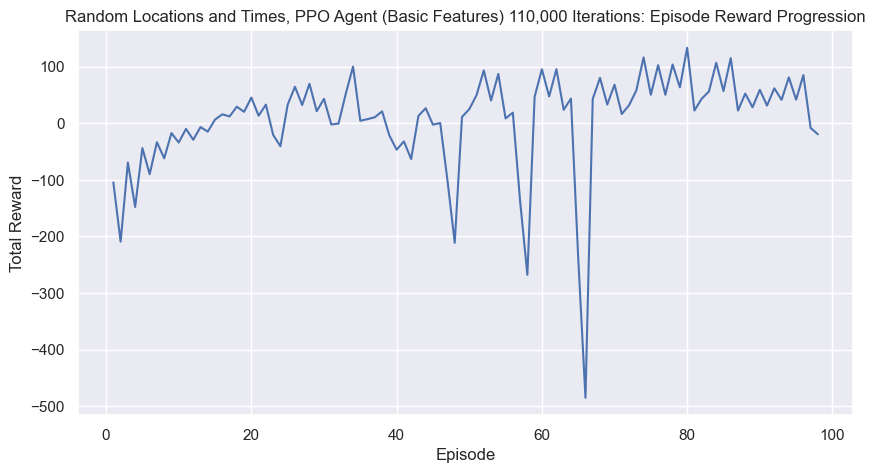

In [14]:
num_eps = np.arange(1, len(reward_callback.rewards) + 1)

fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(num_eps, reward_callback.rewards)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Random Locations and Times, PPO Agent (Basic Features) 110,000 Iterations: Episode Reward Progression')
plt.show()

### Plot of Agent Trades in Held out test set

In [16]:
window = 4
last_index = len(df) - 10
start_index = last_index - VAL_SIZE
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_basic.predict(obs, deterministic=True)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        history = env.history
        env.render_all(title="PPO Agent (Basic Features) Positions on Test Set @ 500,000 Training Steps")
        env.reset()

plt.xlabel("Number of Timesteps (1hr)")
plt.plot()

ValueError: Expected parameter logits (Tensor of shape (1, 3)) of distribution Categorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]])

In [16]:
# PPO_power_basic = PPO.load("agents/PPO_power_random")


FileNotFoundError: [Errno 2] No such file or directory: 'agents\\PPO_power_random.zip'

# Explainability

In [17]:
window = 4
last_index = len(df) - 10  # look at just the first quarter
start_index = last_index - VAL_SIZE
# last_index = start_index + VAL_SIZE//8
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env.reset()
obs = obs[0]
# store the actions taken for each observatoin
obs_list = []
action_list = []
for i in range(last_index - start_index):
    obs_list.append(obs)
    action, states = PPO_power_basic.predict(obs, deterministic=True)
    action_list.append(action)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        history = env.history
        env.render_all(title="PPO Agent (Basic Features) Positions on Test Set @ 500,000 Training Steps")
        env.reset()

plt.xlabel("Number of Timesteps (1hr)")
plt.plot()

ValueError: Expected parameter logits (Tensor of shape (1, 3)) of distribution Categorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]])

In [24]:
obs_list[0]

array([4.5271555e-01, 3.7644342e-01, 0.0000000e+00, 0.0000000e+00,
       4.5292330e-01, 8.3892618e-04, 0.0000000e+00, 0.0000000e+00,
       4.9340934e-01, 1.6093881e-01, 0.0000000e+00, 0.0000000e+00,
       4.1133795e+00, 5.8368230e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [25]:
obs_list[0][12]
# 12 index corresponds to last prices_signal = prices / da_prices

4.1133795

In [26]:
len(obs_list)

3000

In [27]:
last_prices_signal = [i[12] for i in obs_list]

In [28]:
last_prices_signal = np.array(last_prices_signal)

In [29]:
last_pct_diff = [i[13] for i in obs_list]
last_pct_diff = np.array(last_pct_diff)

In [30]:
actions_array = np.array(action_list)

In [31]:
# Discharge = 0
# Charge = 1
# Hold = 2

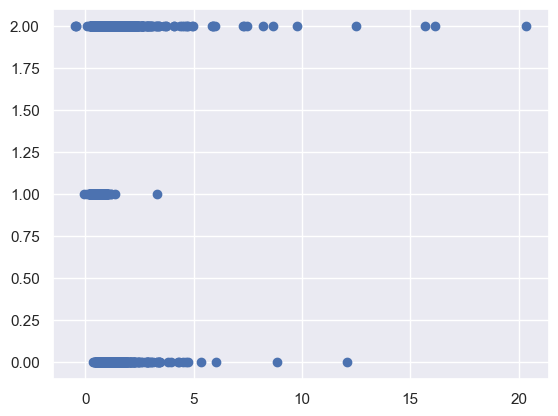

In [32]:
plt.scatter(last_prices_signal, actions_array)

(array([2.75e+03, 2.14e+02, 1.90e+01, 8.00e+00, 4.00e+00, 0.00e+00,
        2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00]),
 array([-0.4463616 ,  1.63432217,  3.71500587,  5.79568958,  7.87637329,
         9.957057  , 12.03774071, 14.11842442, 16.19910812, 18.27979088,
        20.36047554]),
 <BarContainer object of 10 artists>)

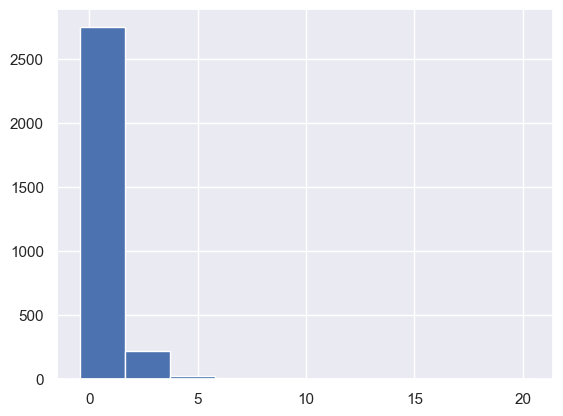

In [33]:
plt.hist(last_prices_signal)

In [34]:
from scipy import stats

In [35]:
# Discharge = 0
# Charge = 1
# Hold = 2

In [36]:
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==0, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==1, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==2, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog

In [37]:
np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))

array([-0.4463616 ,  0.58161218,  0.68916585,  0.7703258 ,  0.84039999,
        0.91971943,  0.99676844,  1.07975301,  1.22427781,  1.53691558,
       20.36047554])

In [38]:
bin_edges

array([-0.4463616 ,  0.58161217,  0.68916583,  0.7703258 ,  0.8404    ,
        0.91971946,  0.9967684 ,  1.079753  ,  1.2242779 ,  1.5369155 ,
       20.360476  ], dtype=float32)

In [39]:
# Discharge = 0
# Charge = 1
# Hold = 2

Text(0, 0.5, 'Frequency of action')

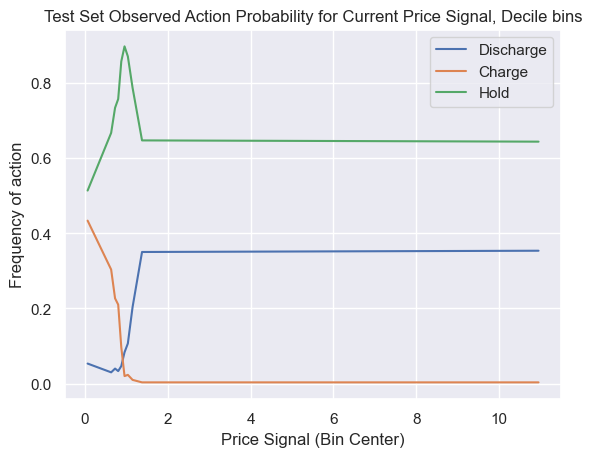

In [40]:
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Price Signal, Decile bins")
plt.xlabel('Price Signal (Bin Center)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

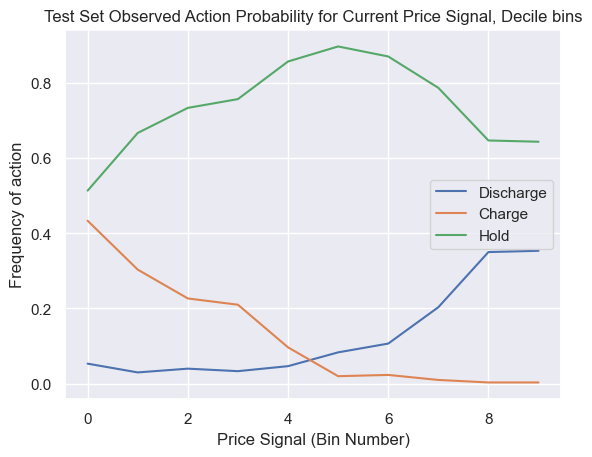

In [41]:
plt.plot(pDischarge, label = 'Discharge')
plt.plot(pCharge, label = 'Charge')
plt.plot(pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Price Signal, Decile bins")
plt.xlabel('Price Signal (Bin Number)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

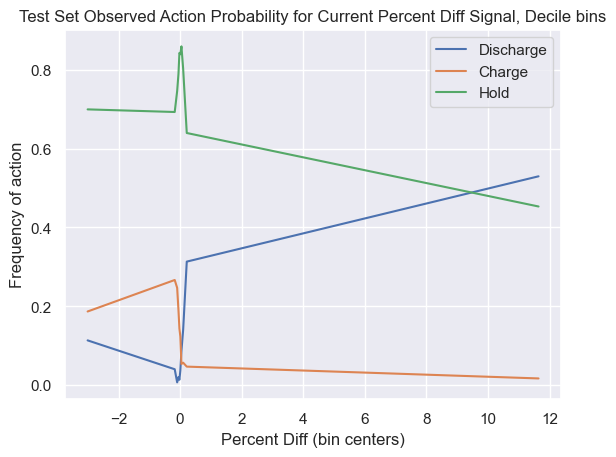

In [42]:
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==0, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==1, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==2, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Percent Diff Signal, Decile bins")
plt.xlabel('Percent Diff (bin centers)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

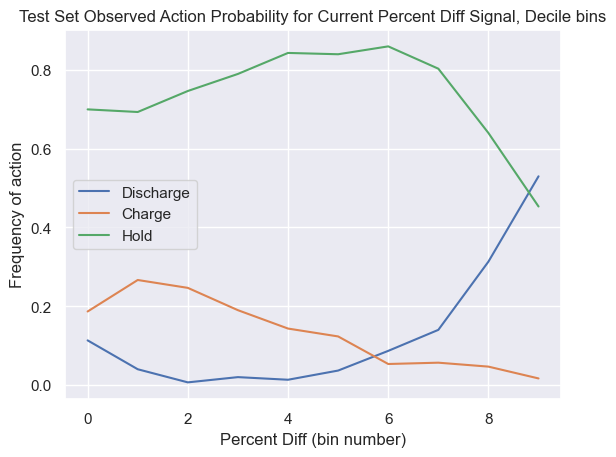

In [43]:
plt.plot(pDischarge, label = 'Discharge')
plt.plot(pCharge, label = 'Charge')
plt.plot(pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Percent Diff Signal, Decile bins")
plt.xlabel('Percent Diff (bin number)')
plt.ylabel('Frequency of action')

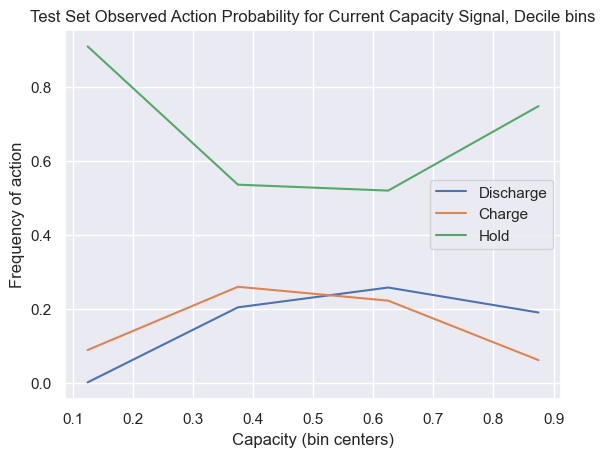

In [50]:
signal = [i[14] for i in obs_list]
signal = np.array(signal)
bin_percentile_size = .01
pDischarge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==0, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==1, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==2, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Capacity Signal, Decile bins")
plt.xlabel('Capacity (bin centers)')
plt.ylabel('Frequency of action')
plt.show()

Text(0, 0.5, 'Frequency of action')

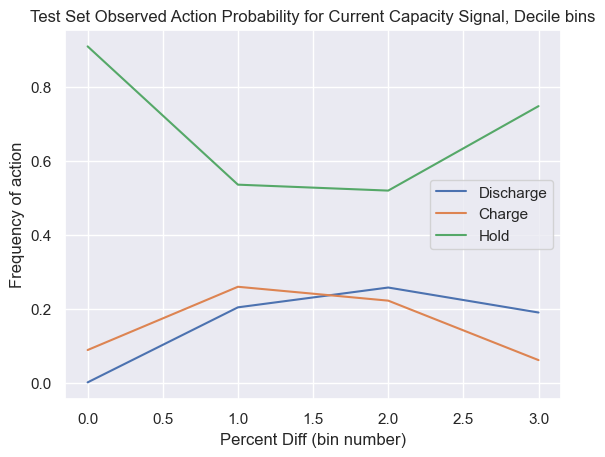

In [51]:
plt.plot(pDischarge, label = 'Discharge')
plt.plot(pCharge, label = 'Charge')
plt.plot(pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Capacity Signal, Decile bins")
plt.xlabel('Percent Diff (bin number)')
plt.ylabel('Frequency of action')

In [52]:
pDischarge = []
pCharge = []
pHold = []
for val in np.unique(signal):
    pDischarge.append(np.mean(actions_array[signal == val] ==0))
    pCharge.append(np.mean(actions_array[signal == val] ==1))
    pHold.append(np.mean(actions_array[signal == val] ==2))

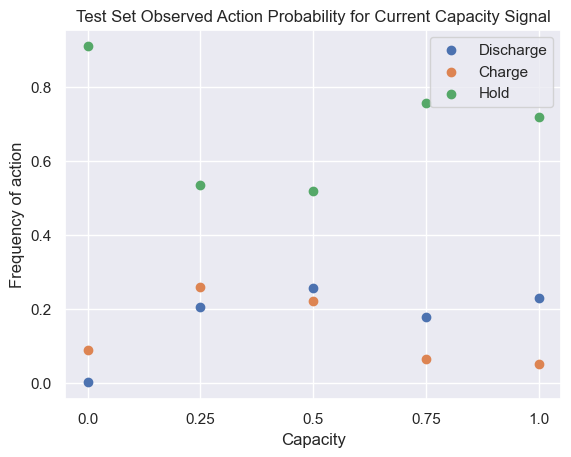

In [53]:
fig, ax = plt.subplots()
ax.scatter(range(len(pHold)),pDischarge, label = 'Discharge')
ax.scatter(range(len(pHold)),pCharge, label = 'Charge')
ax.scatter(range(len(pHold)),pHold, label = 'Hold')
ax.legend()
ax.set_title("Test Set Observed Action Probability for Current Capacity Signal")
ax.set_xlabel('Capacity')
ax.set_ylabel('Frequency of action')
ax.set_xticks(range(len(pHold)),labels = np.unique(signal))

In [54]:
bin_edges

array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32)

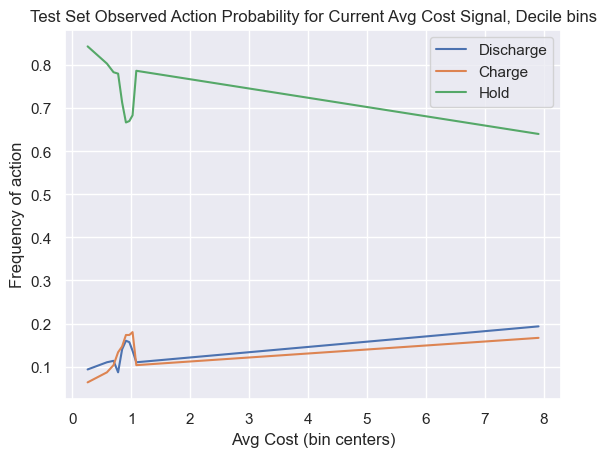

Text(0, 0.5, 'Frequency of action')

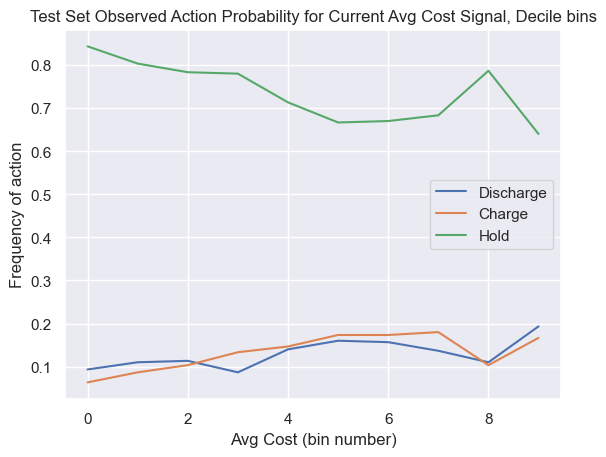

In [55]:
signal = [i[15] for i in obs_list]
signal = np.array(signal)
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==0, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==1, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==2, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Avg Cost Signal, Decile bins")
plt.xlabel('Avg Cost (bin centers)')
plt.ylabel('Frequency of action')
plt.show()
fig, ax = plt.subplots()
ax.plot(pDischarge, label = 'Discharge')
ax.plot(pCharge, label = 'Charge')
ax.plot(pHold, label = 'Hold')
ax.legend()
ax.set_title("Test Set Observed Action Probability for Current Avg Cost Signal, Decile bins")
ax.set_xlabel('Avg Cost (bin number)')
ax.set_ylabel('Frequency of action')


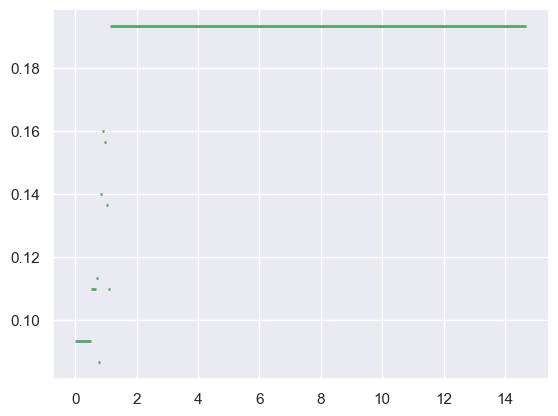

In [56]:
plt.hlines(pDischarge, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
        label=f'Discharge')# symlog


In [57]:
np.arange(0,1+bin_percentile_size,bin_percentile_size)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [58]:
def bin(df, column_str, bin_percentile_size = .05):
    """ver npunique"""
    bin_means, bin_edges, binnumber = stats.binned_statistic((df[column_str]), df['PDs'],# symlog
        statistic='mean', bins=np.unique((df[column_str]).quantile(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
    # bin_means, bin_edges, binnumber = stats.binned_statistic((df[column_str]), df['target_int'],
    #     statistic='mean', bins=(df[column_str]).quantile(np.arange(0,1.05,0.05)))
    bin_width = (bin_edges[1:] - bin_edges[:-1])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_means, bin_centers, bin_width, bin_edges, binnumber


In [59]:
PPO_power_basic = PPO.load("agents/PPO_power_basic_500k")


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


### Reward Statistics over 100 Episodes

### Reward Evolution on Held Out Data

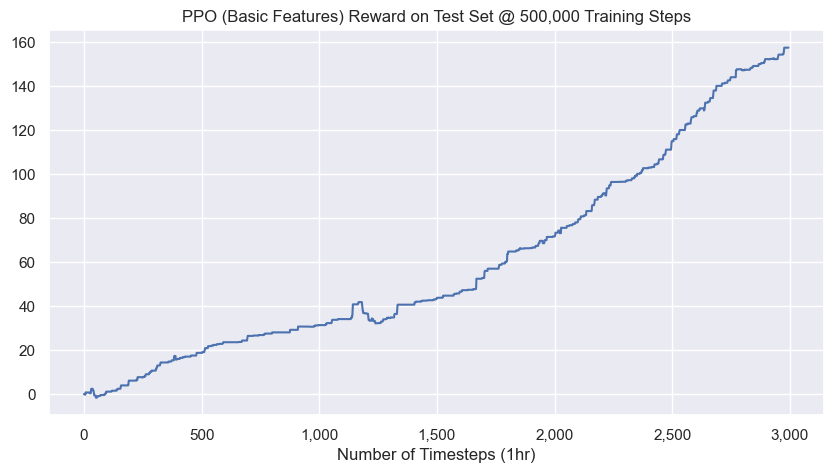

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(history['total_reward'])

plt.title("PPO (Basic Features) Reward on Test Set @ 500,000 Training Steps")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge Management

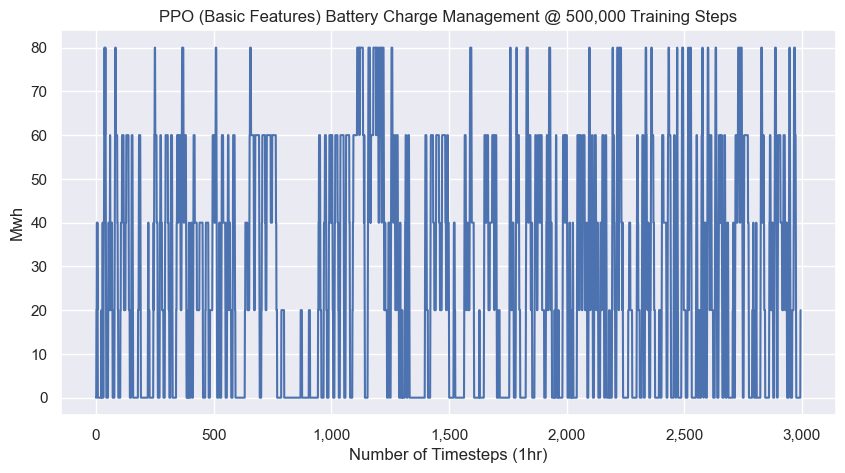

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(history['battery_charge'])

plt.title("PPO (Basic Features) Battery Charge Management @ 500,000 Training Steps")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Profit Evolution on Held Out Data

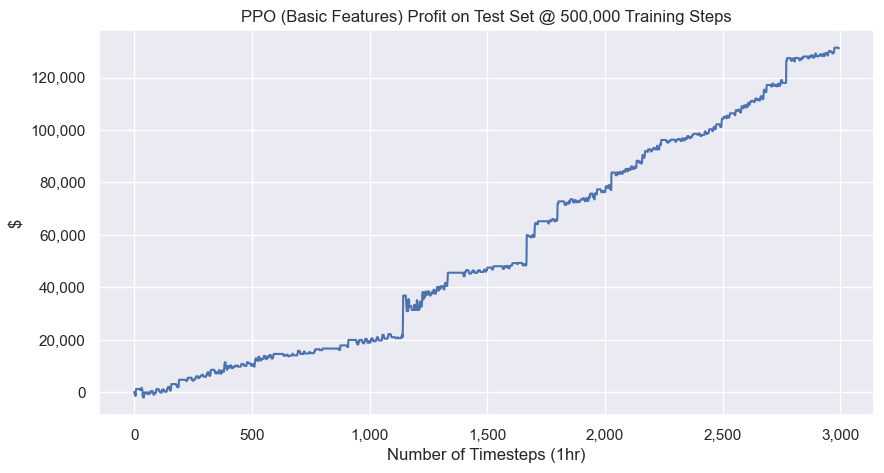

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'y')
format_axis_commas(ax, 'x')
ax.plot(history['total_profit'])

plt.title("PPO (Basic Features) Profit on Test Set @ 500,000 Training Steps")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [63]:
# PPO_power_basic.save('PPO_power_basic_500k')

## PPO Agent with Advanced Features

### (4-hr Observation Window, 552,000 training iterations) 

Environment Observation Comprised of:
-  Current Price (\$/Mwh) 
-  DA Price \($/Mwh)
-  Battery State of Charge (%)
-  Battery Avg Energy Price (\$/Mwh) / Battery Avg Energy Price Window-period Rolling Avg \($/Mwh)

Rewards: 

    - Log Return of profitable discharges: Revenue / Power Sold * Stored Power Cost Basis
    - Log of revenue when selling power with negative cost basis: ln(revenue + |Stored Power Cost Basis|)

Penalty:

    - Overcharging (-1)
    - Discharging When Empty (-1)
    - Losing Money (-1)

In [ ]:
%%time
window = 4 # hours
total_timesteps = 552_000
train_window = 240 # hrs 
n_envs = 4
validation_size = 3000
batch_timesteps = train_window * 1 * n_envs # 1 batch of train_window x window observations for each environment 

# Produce Observations across 16 parallel environments 
venv2 = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=window, frame_bound=(0, train_window)), n_envs=n_envs) 
PPO_power_adv = PPO('MlpPolicy', venv, device='cpu')
logger_adv = VecRewardLogger(verbose=1)

# Walk forward during training to simulate real environment + reduce agent memorization
num_hours = (df.shape[0] - validation_size)
num_eps = num_hours // train_window
num_epochs = total_timesteps // (batch_timesteps * num_eps)

for epoch in range(num_epochs):
    for i in range(num_eps):
        start_day = i * train_window
        end_day = start_day + train_window 
        venv2.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        # Learn on currrent minibatch
        PPO_power_adv.learn(total_timesteps=batch_timesteps, callback=logger_adv, reset_num_timesteps=False)

### Episode Reward Progression

In [ ]:
num_eps = np.arange(1, len(logger_adv.rewards) + 1)

plt.figure(figsize=(10, 5))
plt.plot(num_eps, logger_adv.rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Agent (Advanced Features) 552,000 Iterations: Episode Reward Progression')
plt.grid(True)
plt.show()

### Plot of Agent Trades in Held out test set

In [ ]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_adv.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="PPO Agent (Advanced) Positions on Test Set @ 552,000 Training Steps", xlim=(1100, 1500))
        env2.reset()

plt.plot()

### Reward Statistics over 100 Episodes

In [ ]:
mean_reward, reward_std = evaluate_policy(PPO_power_adv, env2, n_eval_episodes=100)
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

### Reward Evolution on Held Out Data

In [ ]:
plt.plot(history['total_reward'])
plt.title("PPO Agent (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge Management

In [ ]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("PPO Agent Battery Charge (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Profit Evolution on Held Out Data

In [ ]:
plt.plot(history['total_profit'])
plt.title("PPO Agent Profit (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [ ]:
PPO_power_adv.save('PPO_power_advanced_552k')